<!--NAVIGATION-->
< [**Previous:** 02 - Import and Tidy](02-Import & Tidy.ipynb) | [**Next:** 04 - Modeling](04-Modeling.ipynb) >

# Exploratory Data Analysis

The purpose of this notebook is to explore this dataset with visualizations.

In [1]:
import pandas as pd
import numpy as np
import altair as alt
from altair import limit_rows
from matplotlib import pyplot as plt
%matplotlib inline

## Be Able to Use More Rows than the default 5000

In [2]:
def custom(data):
    return alt.pipe(data, alt.to_json(
        base_url='https://data301.calpolydatascience.org/user/anikethb'
    ))

In [3]:
alt.data_transformers.register('custom', custom)
alt.data_transformers.enable('custom')

## Import Dataset From Tidy

In [4]:
dataset= pd.read_csv('/data/anikethb/tidy_dataset.csv')

In [5]:
dataset.head()

,Event Clearance Code,Event Clearance Description,Event Clearance SubGroup,District/Sector,Zone/Beat,Census Tract,Longitude,Latitude
0,242.0,FIGHT DISTURBANCE,DISTURBANCES,M,M2,8100.2001,-122.338147,47.610975
1,65.0,THEFT - MISCELLANEOUS,THEFT,Q,Q1,5700.1012,-122.404613,47.658325
2,250.0,"MISCHIEF, NUISANCE COMPLAINTS","NUISANCE, MISCHIEF COMPLAINTS",M,M2,7200.2025,-122.342843,47.613551
3,460.0,TRAFFIC (MOVING) VIOLATION,TRAFFIC RELATED CALLS,D,D1,7200.1002,-122.341847,47.625401
4,250.0,"MISCHIEF, NUISANCE COMPLAINTS","NUISANCE, MISCHIEF COMPLAINTS",D,D1,6700.1009,-122.339709,47.627425


## Zone vs Number of Incidents

First, I want to inspect the relationship between Zone/Beat and the number of crimes that happen in each one. To do this, I need to create a dataframe with 2 columns: Zone/Beat, and one with the number of crimes/911 calls in that zone.

In [6]:
incidents_count = dataset.groupby('Zone/Beat', as_index=False)['Longitude'].count()
incidents_count_df = pd.DataFrame(incidents_count)
incidents_count_df = incidents_count_df[incidents_count_df['Longitude'] > 1500]

I am using the count aggregate on the 'Longitude' column to get the number of incidents per zone. Any column could've been used, since all I need is the number of rows that each zone has in this dataset. In addition, a filter is in place so that only zones with over 1500 crimes will be kept in the dataframe. Anything less than that is too low of a number to analyze.

In [7]:
incidents_count_df.sort_values(['Longitude'], ascending=False, inplace=True)
incidents_count_df.head()

,Zone/Beat,Longitude
50,M2,48317
40,K2,46922
51,M3,44108
41,K3,43930
19,E2,43177


Of those filtered rows, I sort it by decreasing number of incidents to get a gist of whether or not there is a certain relationship between zones and number of crimes. At glance, we can see that 6 of the top 7 zones with the most incidents come from either the M or K districts.  

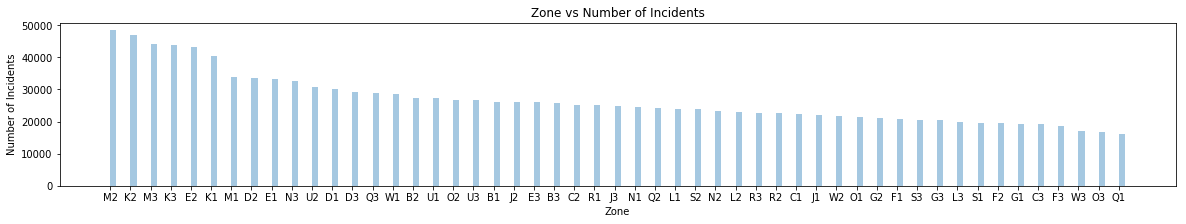

In [8]:
zones = incidents_count_df['Zone/Beat']
num_incidents = incidents_count_df['Longitude']
y_pos = np.arange(len(zones))

plt.figure(figsize=(20,3))
plt.bar(y_pos, num_incidents, align = 'edge', alpha = 0.4, width=0.3)
plt.xticks(y_pos, zones)
plt.xlabel('Zone')
plt.ylabel('Number of Incidents')
plt.title('Zone vs Number of Incidents');

Here, we plot the relationship between zone and the number of incidents, using the sorted incidents_count dataframe. We can visually see how the most of the zones that have the highest number of incidents come from the M and K districts. Due to this, I want to dive deeper into this relationship and see how the districts compare to one another in terms of the number of incidents.

## District vs Number of Incidents

In [9]:
district_incidents = dataset.groupby('District/Sector', as_index=False)['Longitude'].count()
district_incidents_df = pd.DataFrame(district_incidents)

district_incidents_df = district_incidents_df[district_incidents_df['Longitude'] > 1500]

district_incidents_df.sort_values(['Longitude'], ascending=False, inplace=True)

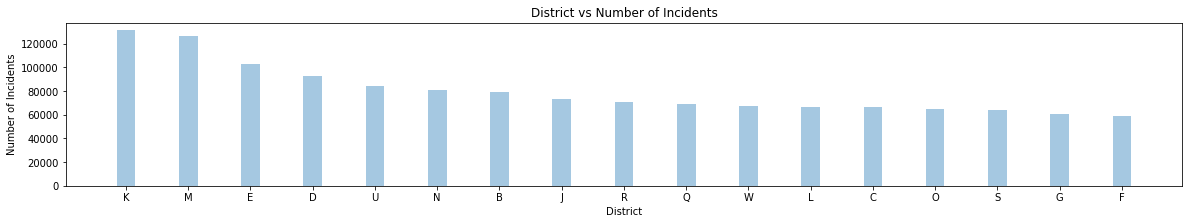

In [10]:
zones = district_incidents_df['District/Sector']
num_incidents = district_incidents_df['Longitude']
y_pos = np.arange(len(zones))

plt.figure(figsize=(20,3))
plt.bar(y_pos, num_incidents, align = 'center', alpha = 0.4, width=0.3)
plt.xticks(y_pos, zones)
plt.xlabel('District')
plt.ylabel('Number of Incidents')
plt.title('District vs Number of Incidents');

After plotting the relationship between district and the number of incidents, we can see that my conjecture above is confirmed, with districts K and M having a considerably larger amount of crimes/incidents than other districts. 

## Distance From Center of City vs Number of Incidents

When looking at the Zone/Beat map of Seattle, I found that Districts K and M are around the center of the city. Due to this, an interesting relationship that I want to explore is the possible correlation between distance from the center of Seattle to the number of crimes that occur in that area. To do this, we need to first create a new column that holds the value of the distance from the center of Seattle. We need to use the given longitude and latitude values in the dataset to do this.

We have to use the **haversine formula** to calculate the "great-circle" distance between two points(the shortest distance over the Earth's surface). The coordinates for the center of Seattle are (47.6223, -122.3522)

**Haversine formula**
$$
a = sin^2(\frac{\Delta\phi}{2}) + cos(\phi1)cos(\phi2)sin^2(\frac{\Delta\lambda}{2})
$$

$$
c = 2 * sin^-1(\sqrt{a})
$$

                                         r = 3956 (radius of earth in miles, use 6371 for km)

                                         d = c * r

where 

- $ \Delta\phi $ is the difference between the two latitudes
- $ \phi $ is the latitude
- $ \Delta\lambda $ is the difference between the two longitudes
- $ \lambda $ is the longitude
- d is the final calculated distance in miles


In [11]:
from math import radians, cos, sin, asin, sqrt

def distance_from_center(row):
    '''Returns a value for the distance from the center of Seattle'''
    return haversine(row['Latitude'], row['Longitude'])
    
def haversine(lat, long):
    '''Calculate the great circle distance between two points on the earth (specified in decimal degrees) in miles'''
    
    lon_center = -122.3522 #Longitude of the center of Seattle
    lat_center = 47.6223 #Latitude of the center of Seattle
    
    # convert decimal degrees to radians 
    lon, lat, lon_center, lat_center = map(radians, [long, lat, lon_center, lat_center])

    # haversine formula 
    diff_lat = lat_center - lat 
    diff_lon = lon_center - lon
    a = sin(diff_lat/2)**2 + cos(lat) * cos(lat_center) * sin(diff_lon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3956       # Radius of earth in miles
    
    return c * r #Returns final distance

To test the haversine function, I am looking up the actual distance between the coordinates on the internet and comparing it with the output of the function.

In [20]:
#Tests to make sure my haversine function works
assert haversine(47.6345, -122.4453) - 4.416 <= 0.001
assert haversine(47.6245, -122.5453) - 8.991 <= 0.001
assert haversine(47.6223, -122.3522) - 0 <= 0.001

Now, we create the new column in the DataFrame

In [13]:
#Takes a few minutes to run
dataset['Distance From Center'] = dataset.apply(distance_from_center, axis=1)

In [14]:
dataset.head()

,Event Clearance Code,Event Clearance Description,Event Clearance SubGroup,District/Sector,Zone/Beat,Census Tract,Longitude,Latitude,Distance From Center
0,242.0,FIGHT DISTURBANCE,DISTURBANCES,M,M2,8100.2001,-122.338147,47.610975,1.019422
1,65.0,THEFT - MISCELLANEOUS,THEFT,Q,Q1,5700.1012,-122.404613,47.658325,3.483148
2,250.0,"MISCHIEF, NUISANCE COMPLAINTS","NUISANCE, MISCHIEF COMPLAINTS",M,M2,7200.2025,-122.342843,47.613551,0.744654
3,460.0,TRAFFIC (MOVING) VIOLATION,TRAFFIC RELATED CALLS,D,D1,7200.1002,-122.341847,47.625401,0.527233
4,250.0,"MISCHIEF, NUISANCE COMPLAINTS","NUISANCE, MISCHIEF COMPLAINTS",D,D1,6700.1009,-122.339709,47.627425,0.680518


As seen by the output above, the new column "Distance From Center" is now added to the DataFrame.

In [15]:
#Takes around 15 seconds to run
sample = dataset.sample(n=100000)
alt.Chart(sample).mark_bar().encode(
    alt.X('Distance From Center', axis=alt.Axis(title='Distance From Center(miles)'), bin=alt.Bin(step=0.1)),
    alt.Y('count(*):Q', axis=alt.Axis(title = 'Number of Incidents'))    
)

<VegaLite 2 object>

Here, we see that with the exception of incidents from 0-1 mile from the center of Seattle, there is a negative correlation between the distance from the center of Seattle and the number of incients/911 calls.

# Relationship Between the Number of Unique Crimes in a District, the Total Number of Crimes, and the Distance From the Center of the City

Here, we are going to create a new Dataframe that will have columns of "District/Sector", "Distance From Center", the number of unique crimes in each district, and the total number of crimes in each district.

In [16]:
district_distance = dataset.groupby('District/Sector', as_index=False)['Distance From Center'].mean()
district_distance_df = pd.DataFrame(district_distance)

district_unique = dataset.groupby('District/Sector', as_index=False)['Event Clearance SubGroup'].nunique()
district_unique_df = pd.DataFrame(district_unique)

district_num_incidents = dataset.groupby('District/Sector', as_index=False)['Longitude'].count()
district_num_incidents_df = pd.DataFrame(district_num_incidents)
district_num_incidents_df.rename(columns ={'District/Sector': 'districts_2'}, inplace =True)

district_concat_df = pd.concat([district_distance_df, district_unique_df, district_num_incidents_df], axis=1).reindex()
district_concat_df.rename(columns={'Longitude': 'Num_Incidents'}, inplace=True)

In [17]:
alt.Chart(district_concat_df).mark_circle().encode(
    alt.X('Distance From Center', axis=alt.Axis(title='Distance From Center of Seattle(miles)')),
    alt.Y('Event Clearance SubGroup', axis=alt.Axis(title='Number of Unique Crimes')),
    alt.Size('Num_Incidents'),
    alt.Color('District/Sector', type = 'nominal')

)

<VegaLite 2 object>

From this visualization, we can tell that the districts with larger amounts of crime, which are the circles that are the largest, happen to be closer to the center of the city. In addition, all the districts that have a large enough amount of incidents to be shown in the visualization have around the same number of unique crimes. 

# Conclusions That Can Be Made Up To This Point

- Location does play a big role in the total number of crimes, and can be a factor in the amount of the specific types of crime as well. 

- The most important columns that we need now are just the ones that have to do with location, along with the column that I will be predicting(Event Clearance SubGroup). Thus, I will filter the dataframe down to those columns for the Modeling section.

In [18]:
dataset = dataset[['Event Clearance SubGroup', 'District/Sector', 'Zone/Beat', 'Longitude', 'Latitude', 'Distance From Center']]

# Export

In [19]:
# Takes around 20 seconds to run
dataset.to_csv('/data/anikethb/EDA_dataset.csv', sep = ',', index=False)

<!--NAVIGATION-->
< [**Previous:** 02 - Import and Tidy](02-Import & Tidy.ipynb) | [**Next:** 04 - Modeling](04-Modeling.ipynb) >